# Tutorial for *BiLO: Bi-Level Local Operator for PDE inverse problem*

## Overview of Bi-Level Local Operator for PDE Inverse Problems


### Setup

Consider a general PDE constrained optimization problem of the form
$$
\begin{aligned}
&\min_{u} \quad L[u] \\
&\text{s.t.} \quad F(D^ku,\cdots, Du, u, \theta) = 0
\end{aligned}
$$

where $D^k$ is a differential operator of order $k$, $F$ is the PDE that depends on some parameter $\theta$, and $L[u]$ is the data loss, which is a functional of the solution $u$, e.g. $L[u] = ||u - u_{\text{obs}}||^2$, where $u_{\text{obs}}$ is the observed data.

If we know the **Full Solution Operator** $u(x,\theta)$, which solves the PDE for any $\theta$, then the data loss can be written as a function of the parameter $\theta$, $L(\theta)$ and the problem can be solved by gradient descent on $\theta$.


### Local Operator
To know the descent direction for $\theta$, we only need to know the data loss locally around the current $\theta$. Therefore, we only need a **Local Operator** $u(x,\theta)$ that approximates the full solution operator locally around $\theta$. The local operator has two conditions:

1. The residual should be 0 at the current $\theta$. 
$$
F(D^k u(x,\theta), \cdots, Du(x,\theta), u(x,\theta), \theta) = 0
$$


2. The total derivative of the residual with respect to $\theta$ should also be zero. This means small perturbations in $\theta$ only lead to a small change in the residual. 
$$
d_\theta F(D^k u(x,\theta), \cdots, Du(x,\theta), u(x,\theta), \theta) = 0
$$



### Bi-Level local Operator learning

We can approximate the local operator $u(x,\theta;W)$ with a neural network, where $W$ are the parameters of the neural network. The local operator should satisfy the two conditions above. This can be achieved by minimizing the residual loss $\|F(u(\cdot,\theta;W),\theta)\|^2$ and the residual-gradient loss $\|d_\theta F(u(\cdot,\theta;W),\theta)\|^2$. This can be approximate by MSE at some collocation points

This leads to the bi-level optimization problem
$$\begin{aligned}
&\min_{\theta} \quad L(u(x,\theta;W)) \\
&W^*(\theta) = \arg\min_{W} \quad \|F(u(\cdot,\theta;W),\theta)\|^2 + \|d_\theta F(u(\cdot,\theta;W),\theta)\|^2 \\
\end{aligned}$$

where $W$ are the parameters of the local operator $u(x,\theta;W)$, which is a neural network. The first level is the data loss, and the second level is the residual of the PDE and its derivative with respect to $\theta$.



## Problem Setup

We will show how to implement BiLO in PyTorch using a simple scalar PDE example.

$$
\begin{aligned}
& \min_{D} \sum_{i=1}^n(u(x_i) - u_{\text{obs}}(x_i))^2\\
& \text{s.t.   }\quad D u'' = f, \quad u(0) = 0, \quad u(1) = 0,
\end{aligned}
$$

where $u_{\text{obs}}$ is the observed data, $u$ is the solution, and $f = - \pi^2 \sin(\pi x)$. $D$ is an unknown parameter. In this example, the full solution operator is $u(x,D) = \sin(\pi x)/D$


In [21]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 2.0

# set seed
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class DenseNet(nn.Module):
    '''General class for a dense neural network with a variable number of layers and width.'''
    def __init__(self, depth=4, width=64, 
                 output_transform=lambda x, u: u):
        super(DenseNet, self).__init__()
        input_dim = 1
        output_dim = 1
        self.width = width
        self.depth = depth
        self.activation = torch.tanh
        layers = []

        # input layer/embeding layer
        self.input_layer = nn.Linear(input_dim, width)

        # hidden layers (depth - 2)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width) for _ in range(depth - 2)])
        self.output_layer = nn.Linear(width, output_dim)
        
        # Store the output transformation function
        self.output_transform = output_transform
    

    def forward(self, x):
        # Define the forward pass
        act = self.activation
        u = act(self.input_layer(x))
        for layer in self.hidden_layers:
            u = act(layer(u))
        u = self.output_layer(u)
        
        return self.output_transform(x, u)


In [23]:
class ScalarPoisson():
    ''' Class for the scalar Poisson equation D u_xx = f(x) on the domain [0, 1] with Dirichlet boundary conditions.'''
    def __init__(self, D = 1.0):
        self.D = D
        self.p = 1
        self.dataset = {}
    
    def f(self, x):
        ''' fixed forcing term'''
        return -(torch.pi * self.p)**2 * torch.sin(torch.pi * self.p * x)

    def u_exact(self, x, D):
        ''' exact PDE solution for given D '''
        return torch.sin(torch.pi * self.p * x) / D
    
    def get_dataset(self, D0, N_res_train, N_dat_train, N_test, variance = None):
        ''' Generate a dataset for the scalar Poisson equation.'''
        
        self.D0 = D0
        self.dataset['D0'] = torch.tensor(D0)
        self.dataset['D'] = torch.tensor(self.D)

        self.N_res_train = N_res_train
        self.N_dat_train = N_dat_train

        # Collocation points for residual loss
        self.dataset['x_res_train'] = torch.linspace(0, 1, N_res_train).view(-1, 1)

        # Collocation points for data loss
        self.dataset['x_dat_train'] = torch.linspace(0, 1, N_dat_train).view(-1, 1)
        
        self.dataset['x_test'] = torch.linspace(0, 1, N_test).view(-1, 1)
        
        # use exact D for testing
        self.dataset['ugt_test'] = self.u_exact(self.dataset['x_test'], self.D)

        # use D0 for pre-training
        self.dataset['u0_dat_train'] = self.u_exact(self.dataset['x_dat_train'], self.D0)

        # u at ground truth D
        u = self.u_exact(self.dataset['x_dat_train'], self.D)

        # add noise to the data if variance is not None
        if variance is None:
            noise = 0
        else:
            noise = torch.randn_like(u) *  torch.sqrt(torch.tensor(variance))
        
        # (noisy) data for fine-tuning
        self.dataset['u_dat_train'] = u + noise

    def to_device(self, device):
        # move all data to device
        for key in self.dataset:
            self.dataset[key] = self.dataset[key].to(device)

In [24]:
class LocalOperator(DenseNet):
    '''
    represent u(x, D; W), where D is the scalar unknown parameter in the PDE, and W are the learnable weights
    '''
    def __init__(self, fdepth=4, fwidth=64, 
                 output_transform=lambda x, u: u):
        super().__init__(fdepth, fwidth, output_transform)

        self.param_embeddings = nn.Linear(1, self.width, bias=True)

    def embedding(self, x, z):
        '''
        Embedding layer for the coordinate x and PDE parameter z.
        This layer compute y = Wx + b + Rz, where R is a fixed embeding matrix.
        '''
        y = self.input_layer(x) 

        # expand the parameter to the same size as x
        self.params_expand = z.expand(x.shape[0], -1) # map scalar z to (n, 1)
        param_embedding = self.param_embeddings(self.params_expand)
        y += param_embedding
        return y

    def forward(self, x , z):
        # Define the forward pass
        X = self.embedding(x, z)
        X = self.activation(X)
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        u = self.output_layer(X)
        
        return self.output_transform(x, u)

class Bilo(nn.Module):
    def __init__(self, localOp, pde):
        super(Bilo, self).__init__()
        
        self.localOp = localOp
        self.pde = pde
        self.dataset = pde.dataset

        D0 = pde.dataset['D0']
        self.D = nn.Parameter(torch.tensor([[D0]]), requires_grad=True)

        self.param_net = list(self.localOp.parameters())
        self.param_pde = [self.D]

    def residual_grad_loss(self):
        '''
        Compute residual loss and the gradient of the residual loss w.r.t. the pde parameter
        '''
        x = self.dataset['x_res_train']
        x.requires_grad = True
        u = self.localOp(x, self.D)

        u_x = torch.autograd.grad(u, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_xx = torch.autograd.grad(u_x, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u_x))[0]

        # residual
        res = self.localOp.params_expand * u_xx - self.pde.f(x)

        # gradient of the residual
        resgrad = torch.autograd.grad(res, self.localOp.params_expand, grad_outputs=torch.ones_like(res),
        create_graph=True, allow_unused=True)[0]
        
        # 2norm of the residual
        res_loss = torch.mean(res**2)
        # 2norm of the gradient of the residual
        res_grad_loss = torch.mean(resgrad**2)
        
        return  res_loss, res_grad_loss
    
    def pretrain(self, max_iter, wresgrad = 0.1):
        optimizer = torch.optim.Adam(self.localOp.parameters(), lr=1e-3)
        for step in range(max_iter+1):
            optimizer.zero_grad()
            res_loss, resgrad_loss = self.residual_grad_loss()
            total_loss = res_loss + wresgrad * resgrad_loss
            total_loss.backward()
            optimizer.step()
            if step % 100 == 0:
                print(f'Step {step}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, D: {self.D.item():.3f}')
    
    def data_loss(self):
        x  = self.dataset['x_dat_train']
        u  = self.localOp(x, self.D)

        u_dat = self.dataset['u_dat_train']
        loss = torch.mean((u - u_dat)**2)
        return loss
    
    def finetune(self, max_iter, wresgrad = 0.1, lr_upper=1e-3, lr_lower=1e-3):
        # Bilevel optimization with simultaneous gradient descent
        optim_param_group = [
            {'params': self.param_net, 'lr': lr_lower},
            {'params': self.param_pde, 'lr': lr_upper}
        ]
        optimizer = torch.optim.Adam(optim_param_group)

        for step in range(max_iter+1):
            
            # compute the gradient of the upper level data loss w.r.t. the PDE parameter D
            data_loss = self.data_loss()
            grads_param = torch.autograd.grad(data_loss, self.D, create_graph=False)
            self.D.grad = grads_param[0]
            
            # compute the gradient of the lower level local operator loss w.r.t. the network parameters, W of u(x,D;W)
            res_loss, resgrad_loss = self.residual_grad_loss()
            lo_loss = res_loss + resgrad_loss * wresgrad
            grads_net = torch.autograd.grad(lo_loss, self.param_net, create_graph=False)
            for i, param in enumerate(self.param_net):
                param.grad = grads_net[i]
            
            # simultaneous gradient descent at both levels
            optimizer.step()
            if step % 100 == 0:
                print(f'Step {step}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, data_loss: {data_loss.item():.3e}, D: {self.D.item():3f}')

In [25]:
# training colloction points
n_res_train = 11 # number of collocation points for residual loss
n_dat_train = 11 # number of collocation points for data loss
# testing collocation points
n_test = 101 

# variance of the noise
variance = 0.01

D_gt = 2.0 # ground truth D
D0 = 1.0 # initial guess for D

pde = ScalarPoisson(D=D_gt)
pde.get_dataset(D0, n_res_train, n_dat_train, n_test, variance=variance)

### Pre-training

In the pre-training stage, we train BiLO with initial guess $D_0$.

In [26]:
localop = LocalOperator(output_transform=lambda x, u: u * (1 - x)*x)
bilo = Bilo(localop, pde)

bilo.to(device)
pde.to_device(device)

max_iter = 1000
bilo.pretrain(max_iter)

Step 0, res_loss: 4.109e+01, resgrad_loss: 3.575e-02, D: 1.000
Step 100, res_loss: 3.655e-01, resgrad_loss: 2.964e+00, D: 1.000
Step 200, res_loss: 1.533e-03, resgrad_loss: 3.638e-03, D: 1.000
Step 300, res_loss: 1.210e-03, resgrad_loss: 1.823e-03, D: 1.000
Step 400, res_loss: 9.362e-04, resgrad_loss: 1.707e-03, D: 1.000
Step 500, res_loss: 7.267e-04, resgrad_loss: 1.552e-03, D: 1.000
Step 600, res_loss: 5.682e-04, resgrad_loss: 1.331e-03, D: 1.000
Step 700, res_loss: 4.457e-04, resgrad_loss: 1.102e-03, D: 1.000
Step 800, res_loss: 3.495e-04, resgrad_loss: 9.014e-04, D: 1.000
Step 900, res_loss: 2.731e-04, resgrad_loss: 7.407e-04, D: 1.000
Step 1000, res_loss: 2.124e-04, resgrad_loss: 6.167e-04, D: 1.000


### Visualizing BILO

After pre-training at $D_0$, we can evaluate the local operator at its neighborhood $D_0 + \Delta$.
Because of the residual-gradient loss, the local operator is able to approximate the true PDE solution at the neighborhood $D_0 + \Delta$

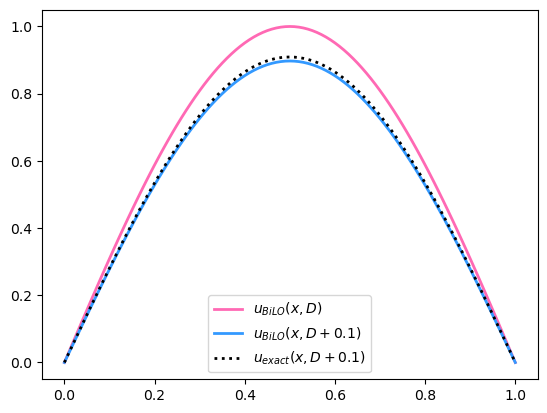

In [27]:
with torch.no_grad():
    bilo.to('cpu')
    pde.to_device('cpu')
    x = pde.dataset['x_test']
    # plot prediction
    u = bilo.localOp(x, bilo.D)
    plt.plot(x, u, label='$u_{BiLO}(x,D)$', color="#FF69B4")
    delta = 0.1
    
    u_var = bilo.localOp(x, bilo.D + delta)

    # plot prediction at D + delta
    plt.plot(x, u_var, label=f'$u_{{BiLO}}(x,D+{delta})$', color='#3399FF')
    # plot solution with predicted D
    plt.plot(x, pde.u_exact(x, bilo.D.item()+delta), label=f'$u_{{exact}}(x,D+{delta})$', linestyle=':', color='black')

plt.legend()
plt.show()

### Fine-tuning/Inference

Next, we solve the inverse problem with the noisy data to infer D.

In [28]:
bilo.to(device)
pde.to_device(device)

max_iter = 3000
bilo.finetune(max_iter,lr_upper=2e-3)

Step 0, res_loss: 2.119e-04, resgrad_loss: 6.156e-04, data_loss: 1.507e-01, D: 1.002000
Step 100, res_loss: 1.430e-04, resgrad_loss: 6.640e-04, data_loss: 8.516e-02, D: 1.178518
Step 200, res_loss: 9.082e-05, resgrad_loss: 1.640e-04, data_loss: 5.660e-02, D: 1.310672
Step 300, res_loss: 7.273e-04, resgrad_loss: 4.860e-04, data_loss: 4.162e-02, D: 1.416727
Step 400, res_loss: 3.384e-05, resgrad_loss: 5.915e-05, data_loss: 3.219e-02, D: 1.505597
Step 500, res_loss: 2.133e-03, resgrad_loss: 1.203e-03, data_loss: 2.649e-02, D: 1.581988
Step 600, res_loss: 1.077e-05, resgrad_loss: 7.881e-05, data_loss: 2.209e-02, D: 1.648894
Step 700, res_loss: 1.067e-03, resgrad_loss: 7.612e-04, data_loss: 1.944e-02, D: 1.708194
Step 800, res_loss: 4.670e-05, resgrad_loss: 1.009e-04, data_loss: 1.704e-02, D: 1.761273
Step 900, res_loss: 6.053e-06, resgrad_loss: 9.589e-05, data_loss: 1.543e-02, D: 1.809121
Step 1000, res_loss: 1.582e-05, resgrad_loss: 1.058e-04, data_loss: 1.419e-02, D: 1.852466
Step 1100, 

In [29]:
with torch.no_grad():
    bilo.to('cpu')
    pde.to_device('cpu')

    x = pde.dataset['x_test']
    u = bilo.localOp(x, bilo.D)

In [ ]:
# Due to the noise, the ground truth D is not the best D for the noisy data.
# We can also use scipy to find the best-fit D, which is considered as the "true" best D under noisy data.
import numpy as np
from scipy.optimize import minimize

# Extract data from torch tensors
x_train = pde.dataset['x_dat_train'].cpu().numpy().flatten()
u_obs = pde.dataset['u_dat_train'].cpu().numpy().flatten()

def loss_fn(D):
    u_pred = np.sin(np.pi * x_train) / D
    return np.mean((u_pred - u_obs) ** 2)

# Initial guess for D
D0 = np.array([1.0])

res = minimize(loss_fn, D0, bounds=[(1e-6, None)])
D_scipy = res.x[0]
print("Best-fit D:", D_scipy)

Best-fit D: 2.2549297748449555


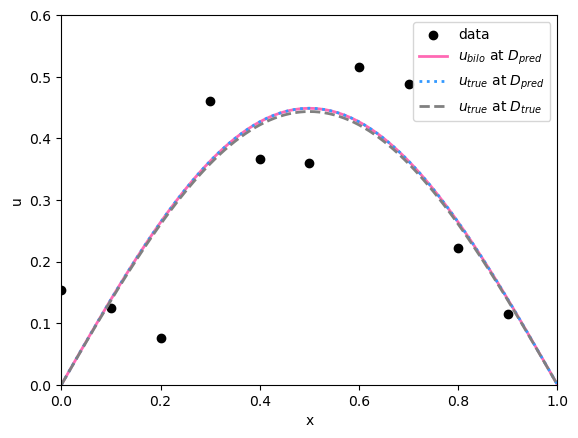

In [31]:
# plot data
plt.scatter(pde.dataset['x_dat_train'], pde.dataset['u_dat_train'], label='data', color='black')
# plot BiLO prediction
plt.plot(x, u, label='$u_{bilo}$ at $D_{pred}$', color="#FF69B4")
# plot solution with ground truth D
# plt.plot(x, pde.u_exact(x, pde.D), label='u_{true} at $D_{gt}$', color='gray')
# plot exact solution with predicted D
plt.plot(x, pde.u_exact(x, bilo.D.item()), label='$u_{true}$ at $D_{pred}$', linestyle=':', color='#3399FF')

plt.plot(x, pde.u_exact(x, D_scipy), label='$u_{true}$ at $D_{true}$', linestyle='--', color='gray')


plt.xlabel('x')
plt.ylabel('u')

plt.xlim(0, 1)
plt.ylim(0, 0.6)

plt.legend()
plt.show()
